# Theory of Regression and Regularization

### Data Science 350
### Stephen F Elston & Nick McClure

In this notebook we will explore the mathematical basis of linear statistical models. The emphasis is on the ubiquitious problem of **model overfitting** or **model over-parameterizaton**. 

Overfitting (or over-parameterization) of machine learning models arrises in any case where the number of model parameters exceeds the effective dimensions of the feature set. This is most often the result of linear dependency between the features. However, using too complex a model can lead to similar problems. In the extreme case, imagine a model with as many free parameters as training cases. This model might fit the training data perfectly, but will show unstable and unexpected results when used for other data. In machine learning terminology, we say that such an unstable model does not **generalize**. 

Many methods have been developed and continue to be developed to deal with over-paramterized or **ill-posed** machine learning models. In particular, in this notebook we will explore three methods for stabalizing over-parameterized models. 

- Stepwise regression, wherein features are eliminated from an over-parameterized model in a stepwise fashon.
- Using a mathematical **regularization** technique, known as singular value decomposision, to determine the number of meaningful components for a model. 
- Using **regularizaton** methods known as ridge, lasso, and elastic-net regression to stabalize over-parameterized models. 

![](img/Extrapolation.png)
<center> **Warning!! Extrapolation can be dangerious!!**


***
**Note:** To run the code in this note book you must have installed the following packages:
 - pandas
 - numpy
 - seaborn
 - scikit-learn
 - statsmodels
 - matplotlib
***

## Stepwise Regression

In this section we will work through an example of stepwise regression using the Gaulton family height data --insert link for information on Gaulton data--. The goal of the model is to predict the hight of adult childrdn given information on the height of their parents. 

### Preparing the data

As a first step we will create a data set for just the adult male children. The code in the cell below performs the following operations:

- Subset the data to just male adult children.
- Compute two new feaures, the heights of the parents squared.
- Zscore scale the features.

Execute this code to prepare the data. 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load data
data_file = 'galton.txt'
height_data = []
with open(data_file, 'r') as f:
    header = next(f)
    header = header.strip().split('\t')
    for row in f:
        height_data.append(row.strip().split('\t'))

# Data is of the from:
#[Family #, Father height, Mother height, Gender, Height, # Kids]
# Convert numeric fields to numeric
height_data = [[x[0], float(x[1]), float(x[2]), x[3], float(x[4]), int(x[5])] for x in height_data]

# Filter for male heights
male_data = [x for x in height_data if x[3]=='M']
print('Number of rows: {}, Number of Males: {}'.format(len(height_data), len(male_data)))

# Filter for just mother height, father height, and individual height
# Also, add in squares of mother and father heights
male_data = [[x[1], x[2], x[4], x[1]**2, x[2]**2] for x in male_data] # Don't run this twice!

male_labels = ['father', 'mother', 'childHeight', 'father_sqr', 'mother_sqr']

# Put in pandas df
male_df = pd.DataFrame(male_data, columns=male_labels)

Number of rows: 898, Number of Males: 465


In [3]:
male_df.head()

,father,mother,childHeight,father_sqr,mother_sqr
0,78.5,67.0,73.2,6162.25,4489.00
1,75.5,66.5,73.5,5700.25,4422.25
2,75.5,66.5,72.5,5700.25,4422.25
3,75.0,64.0,71.0,5625.00,4096.00
4,75.0,64.0,70.5,5625.00,4096.00


In [4]:
# Scale everything but the individual height (child height)
# Create a scale function for a column in a pandas df
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

# Add scaled x to data frame
male_df['father'] = scale(male_df['father'])
male_df['mother'] = scale(male_df['mother'])
male_df['father_sqr'] = scale(male_df['father_sqr'])
male_df['mother_sqr'] = scale(male_df['mother_sqr'])

In [5]:
male_df.head()

,father,mother,childHeight,father_sqr,mother_sqr
0,4.061811,1.284365,73.2,4.309762,1.302257
1,2.756018,1.069935,73.5,2.859293,1.077586
2,2.756018,1.069935,72.5,2.859293,1.077586
3,2.538386,-0.002213,71.0,2.623043,-0.020524
4,2.538386,-0.002213,70.5,2.623043,-0.020524


### Computing a model with all features

As a first step, let's compute a model for the hight of the adult male childern using all available features. Execute the code in the cell below to compute this model, and print and plot evaluation information. 

Intercept, Slopes : 
Intercept     69.228817
father         1.406032
mother        -2.303683
father_sqr    -0.465471
mother_sqr     3.083288
dtype: float64
Intercept t-value, Slope t-values: 
Intercept     648.139786
father          0.346865
mother         -0.547021
father_sqr     -0.114804
mother_sqr      0.731968
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept     0.000000
father        0.728851
mother        0.584630
father_sqr    0.908651
mother_sqr    0.464561
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 773.011233624763
SST: 3213.3338494623654
SSR: 2440.3226158376024
RMSE: 13.901539785440702
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     36.43
Date:                Wed, 29 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


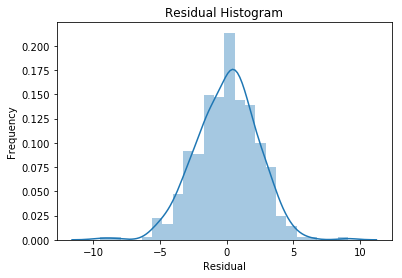

In [6]:
ols_model = sm.ols(formula = 'childHeight ~ father + mother + father_sqr + mother_sqr + 1', data=male_df)

results = ols_model.fit()
n_points = male_df.shape[0]
y_output = male_df['childHeight'].reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

It is clear from the summary that this model is over-parameterized. Only the intercept is significant. In other words, we are computing the average value of the lable (childHeight), but nothing more. Examination of the residual plots shows them to be mostly well behaved, except with a bit of curvature in the standardized residual plot. 

### Apply stepwise regression

Stepwise regression using model performance metrics to prune the number of features in a model. The steps can be forward, wherein features are added one at a time in order of importance, until a point of diminished return is reached. Or, the steps can be backward, wherein a model using all features is puruned one feature at a time in reverse order of importance. It is also possible to step in both directions. In practice, either backward steps or using both directions are used, since forward steps have a tendancy to get stuck at poor solutions. 

A significant issue with stepwise regression is to choose a performance metric. Many commonly used error metrics like RMSE will natually get better as we add more model parameters. Consequently the **Akaike information criterion** (AIC) is often used. We can write the AIC as:

$$AIC = 2 k - 2 ln(\hat{L})\\
where\\
\hat{L} = the\ likelihood\ given\ the\ fitted\ model\ parmaters\ \hat\theta = p(x| \hat\theta)\\
x = observed\ data\\
k = number\ of\ model\ parameters$$

In words, the AIC is the model log-likelihood adjusted for the number of model parameters. The objective is to minimize the AIC. 

The quantity $- 2 ln(p(x| \hat\theta))$ is sometimes reffered to as the **deviance** of the model. Deviance is a measure of the relative likelihood of the model. Deviance is a generalization of the variance. I fact, deviance should be meaured with respect to a staturated model (number of parmeters = number of observations), but this step is often skipped.

In [7]:
def forward_selected(data, response):
    """Linear model designed by forward selection. Based on AIC

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
    """
    # Start with no factors (intercept only)
    formula = "{} ~ 1".format(response)
    best_aic = sm.ols(formula, data).fit().aic
    
    # Go through remaining sets of variables one-by-one
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_aic = best_aic
    
    # Check if any variables remain and if we haven't improved by adding any yet
    while remaining and current_aic == best_aic:
        aic_candidates = []
        for candidate in remaining:
            # Try adding the candidate column
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            # Get AIC
            aic = sm.ols(formula, data).fit().aic
            # Append tuple of the form (aic, response)
            aic_candidates.append((aic, candidate))
        # Sort all the pairs by the first entry of tuple (default of sort() method)
        aic_candidates.sort()
        # Remember that the sort() method sorts by smallest to largest of first entry here.
        #   If you were to change the criteria to something that needs to be maximized, change sort/pop order!
        best_new_aic, best_candidate = aic_candidates.pop(0)
        # Now check if we have something better:
        if best_new_aic < current_aic:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_aic = best_new_aic
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    # Get the model object
    model = sm.ols(formula, data).fit()
    return model

model = forward_selected(male_df, 'childHeight')

print(model.model.formula)

print(model.rsquared_adj)
print(model.aic)

childHeight ~ father + 1
0.151300180344
2145.18396445


# Your Turn

## Backward stepwise selection

Backward stepwise selection is a very similar algorithm.  Fill in the blanks in the following formula for backward stepwise selection:

In [8]:
def backward_selected(data, response):
    """Linear model designed by backward selection. Based on AIC

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
    """
    # Start with all factors and intercept
    possible_factors = set(data.columns)
    possible_factors.remove(response)
    formula = "{} ~ {} + 1".format(response, ' + '.join(possible_factors))
    
    # Fill out this formula!
    #--------------------------------
    # Fill in spot #1!!!!
    best_aic = sm.ols(formula, data).fit().aic
    #--------------------------------
    
    current_aic = best_aic
    
    # Set a non-empty set of columns that will be labeled as "to remove and try"
    to_try_remove = possible_factors
    
    # Check if any variables remain and if we haven't improved by adding any yet
    while to_try_remove and current_aic == best_aic:
        aic_candidates = []
        for candidate in to_try_remove:
            
            columns = possible_factors - set([candidate])
            # Try removing the candidate column
            formula = "{} ~ {} + 1".format(response, ' + '.join(columns))
            # Get AIC
            aic = sm.ols(formula, data).fit().aic
            
            # Append tuple of the form (aic, response)
            aic_candidates.append((aic, candidate))
            
        # Sort all the pairs by the first entry of tuple (default of sort() method)
        aic_candidates.sort()
        # Remember that the sort() method sorts by smallest to largest of first entry here.
        #   If you were to change the criteria to something that needs to be maximized, change sort/pop order!
        best_new_aic, best_candidate = aic_candidates.pop(0)
        
        # Now check if we have something better:
        if best_new_aic < current_aic:
            # Remove the best candidate's name from possible_factors
            
            #--------------------------------
            # Fill in spot #2!!!!
            possible_factors.remove(best_candidate)
            current_aic = best_new_aic
            #--------------------------------
            
        # Now we repeat the process with all the remaining candidate columns

    # Here is the final formula!
    formula = "{} ~ {} + 1".format(response, ' + '.join(possible_factors))
    # Get the model object
    model = sm.ols(formula, data).fit()
    return model

backwards_model = backward_selected(male_df, 'childHeight')

print(backwards_model.model.formula)

print(backwards_model.rsquared_adj)
print(backwards_model.aic)

childHeight ~ mother_sqr + father + mother + 1
0.235599620083
2098.52553632


--------------------
# Your Turn

## Python Question:

In the above code you filled out (prior cell), in the position labeled `Fill in spot #2`, why do we _not_ need the following command:

`to_try_remove.remove(best_candidate)`

Hint:  Try the following code in python:

`
a = set([1, 2, 3])
b = a
b.remove(1)
print(b)
print(a)
`


Now that we have a backwards-selected formula : `childHeight ~ father + mother + mother_sqr + 1`, let's use that formula to get the statistics of the model.

Intercept, Slopes : 
Intercept     69.228817
father         0.940834
mother        -2.256549
mother_sqr     3.035847
dtype: float64
Intercept t-value, Slope t-values: 
Intercept     648.834608
father          8.748704
mother         -0.538971
mother_sqr      0.724975
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept     0.000000e+00
father        4.083633e-17
mother        5.901674e-01
mother_sqr    4.688354e-01
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 772.9413135437526
SST: 3213.3338494623654
SSR: 2440.392535918613
RMSE: 16.05138948859519
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     48.67
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           2.42e-27
Time:  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


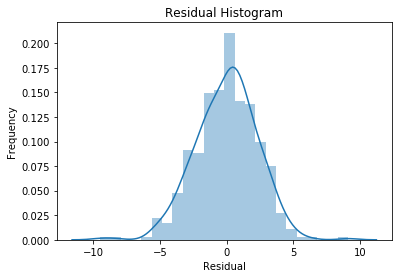

In [9]:
# Linear model stats
ols_model_forward = sm.ols(formula = 'childHeight ~ father + mother + mother_sqr + 1', data=male_df)

results = ols_model_forward.fit()
n_points = male_df.shape[0]
y_output = male_df['childHeight'].reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

### Adding an interaction term

We will try one last idea, adding an interaction term. In this case we will compute all possbile interactions between the heights of the mother and the father, `mother`, `father`, and the interaction term: `mother X father`. 

Execute the code in the cell below to compute the model and print and plot the results. 

Intercept, Slopes : 
Intercept        69.223885
father            0.944032
mother            0.775070
mother:father     0.046383
dtype: float64
Intercept t-value, Slope t-values: 
Intercept        645.538364
father             8.788367
mother             7.210669
mother:father      0.475625
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept        0.000000e+00
father           3.019678e-17
mother           2.297275e-12
mother:father    6.345668e-01
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 771.3573224714096
SST: 3213.3338494623654
SSR: 2441.976526990956
RMSE: 16.034933972126915
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     48.54
Date:                Wed, 29 Nov 2017   Prob (F-s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


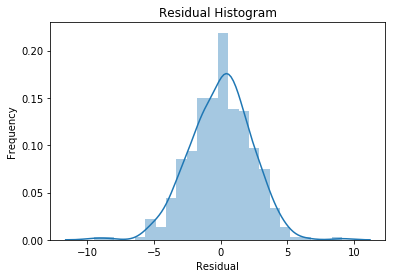

In [10]:
# Linear model stats
ols_model_forward = sm.ols(formula = 'childHeight ~ father + mother + mother*father + 1', data=male_df)

results = ols_model_forward.fit()
n_points = male_df.shape[0]
y_output = male_df['childHeight'].reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

It is clear from the summary that the interaction term is not significant. The best model we have to this point is the one computed with stepwise regression. 

***
**Note:** Stepwise regression appears to be a simple method for feature selection. However, be aware that **stepwise regresson does not scale well**. As with any multiple comparison method, stepwise regresson suffers from a high probability of false positive results. In this case, a feature which should be dropped might not be, because of a low p-value or AIC. 
***

## Regularization: Singular Value Decomosition

Now that we have explored both manual feature selection and stepwise regression, we will examine regularization methods. Regularization methods stabalize the inverse of the **model matrix**. In this section we will use the singular value decomposition method to stabalize a model matrix. 

You may well wonder why we need regularization methods, when we have tools like stepwise regression. Two important reasonse are:

- Stepwise regression is a compuationally intensive process, since we must recompute the model many times. There are methods that allow computation of the updated model, but with a large number of features there are numerious permutations. We need methods that can handel hundreds, thousands, or even millions of features.

> Note: Consider a small data set with only 20 features.  The amount of possible linear models with NO interaction terms is given by:  $\binom{20}{1} + \binom{20}{2} + \binom{20}{3} + \dots + \binom{20}{20}$, which is the sum of the 21st row of the Pascal's triangle.  This comes out to be $2^{20} = 1,048,576$.  Although, according to our algorithm, this would be the maximum number of models to compute, you can see how computationally hard this becomes.

- With stepwise regression a feature is either in or out of the model. This may not be the best choise. Perhaps a reweighting the features in some way might be better. 
- Stepwise regression suffers from issues inherent in multiple comparisons. 

In order to understand the motivation and methods of feature selection/transformation, we will start with reviewing some linear algebra.

### Linear Algebra Review

Before we get into the details of regularizaton, let's review some basic linear algebra.

For this part of the notebook we will be using the library `numpy`, which is the numerical python library.

> Note: In python there are a few distinctions to make.  The base python has a variable type called 'Lists'. Lists are just that. They are lists of objects. `[5, 'foobar', True, ...]`. While we can make a list that contains all numbers: `[2.0, 2.0, 2.0]`, this is not a vector nor matrix.  The package `numpy` introduces arrays (vectors and matrices) which have the correct associated matrix properties.

> Note: Please be careful using Jupyter Notebook. Jupyter displays arrays the same as lists (you'll see in examples below).  It is even the case that some Numpy functions and objects will interact with lists the same way, but sometimes they do not and it can be frustrating to troubleshoot if they appear the same.  Always read documentation and check the types of your variables with the command `type(my_variable)`.

Let's start by creating two vectors of length 3.

In [11]:
a_list = [2]*3
print(a_list)
print(type(a_list))
a = np.array([2]*3)
print(a)
print(type(a))
b = np.arange(1, 4)
print(b)
print(type(b))

[2, 2, 2]
<class 'list'>
[2 2 2]
<class 'numpy.ndarray'>
[1 2 3]
<class 'numpy.ndarray'>


We can perform some basic element-wise arithmetic opertions on vectors.

In [12]:
print(a + b)
print(a * b)

[3 4 5]
[2 4 6]


These vectors are both dimension (size) three.

We can do the same in two - dimensional matrices as follows:

In [13]:
a2d = np.array([[2]*3, [3]*3])
print('a: \n{} \n a-size: {}'.format(a2d, a2d.shape))
b2d = np.reshape(np.arange(1,7), newshape=(2, 3))
print('\nb: \n{} \n b-size: {}'.format(b2d, b2d.shape))

# Addition
print('\nAddition: \n {}'.format(a2d + b2d))
# Multiplication
print('\nMultiplication: \n {}'.format(a2d * b2d))

a: 
[[2 2 2]
 [3 3 3]] 
 a-size: (2, 3)

b: 
[[1 2 3]
 [4 5 6]] 
 b-size: (2, 3)

Addition: 
 [[3 4 5]
 [7 8 9]]

Multiplication: 
 [[ 2  4  6]
 [12 15 18]]


We can also _transpose_ a two-dimensional matrix by flipping the rows and columns.

In [14]:
print('Try transposing on a vector...')
print(np.transpose(a))
# Uh oh!  Transpose on a vector doesn't do anything...

print('Now reshape a into 2D and then transpose:')
print(np.transpose(np.reshape(a, newshape=(1,3))))
print('Now transpose a 2d matrix:')
print(np.transpose(a2d))

Try transposing on a vector...
[2 2 2]
Now reshape a into 2D and then transpose:
[[2]
 [2]
 [2]]
Now transpose a 2d matrix:
[[2 3]
 [2 3]
 [2 3]]


We can also compute the **dot product**, which is also known as the **scalar product** or **inner product** of two vectors of equal length.

$$dot\ product = \Sigma_i^n a_i \cdot b_i$$

Give the dot product a try by executing the code in the cell below.

In [15]:
print('np.dot(a, b) = np.dot({}, {})'.format(a, b))
np.dot(a, b)

np.dot(a, b) = np.dot([2 2 2], [1 2 3])


12

The square root of the inner product of a vector with itself is the length or $L2$ norm of the vector.

$$\parallel a \parallel = length\ of\ vector\ a = \sqrt{a \cdot a}$$

--------------------

# Your Turn

Create and exectue the code to compute the length or norm of the vector `a` in the cell below.

In [16]:
def inner_prod(vec1, vec2):
    # Fill in the following calculation:
    inner_prod_calc = 
    return inner_prod_calc

def l2_norm(my_vec):
    # Fill in the following calculation:
    l2_norm_calc = 
    return l2_norm_calc

print('L2 Norm of {} = {}'.format(a, l2_norm(a)))
# Should get ~3.4641016151377544

L2 Norm of [2 2 2] = 3.4641016151377544


We can also write the inner product as:

$$a \cdot b = \parallel a \parallel \parallel b \parallel cos(\theta)\\
or \\
cos(\theta) = \frac{a \cdot b}{\parallel a \parallel \parallel b \parallel}$$

Notice that the inner product of orthogonal vectors is $0$. Run the code in the cell below to see an example.

In [17]:
aa = np.array([1, 0, 0])
bb = np.array([0, 1, 1])
print(inner_prod(aa, bb))

0


Let's try some operations on martricies. Let $A$  and $B$ be $m = 4$ rows by $n = 3$ columns matrices. 

In [18]:
A = np.array([[4]*3]*4) # A has 4 rows and 3 columns
print(A)
B = np.array(np.reshape(np.arange(1, 13), newshape = (4, 3)))
print(B)

[[4 4 4]
 [4 4 4]
 [4 4 4]
 [4 4 4]]
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


We can perform some arithmatic operations element by element on these matrces.

In [19]:
print(A + B)
print(A * B)

[[ 5  6  7]
 [ 8  9 10]
 [11 12 13]
 [14 15 16]]
[[ 4  8 12]
 [16 20 24]
 [28 32 36]
 [40 44 48]]


We can multiply a $mxn$ matrix by a vector of length $n$ by taking the inner product of each row of the matrix and the vector. The result in a vector of length $n$. Each element of the result can be written at:

$$y_i = \Sigma_j^m A_{ij} \cdot b_j$$

Run the code in the cell below and examine the result. 

In [20]:
np.dot(A, b)

array([24, 24, 24, 24])

So, how do we multipy two matrices? In matrix multiplcation each element of the resulting matrix is the inner product of a row by a column. For example, the element $Y_{ij}$ of the result matrix is computed as follows:

$$Y_{ij} = \Sigma_j^m A_{ij} \cdot B_{ji}$$

Notice that the number of columns, $m$, of the first matrix must equal the number of rows of second matrix. And, that the number of rows, $n$ of the first matrix must equal the number of columns of the second metrix. In this case, the two matricies are said to be **conformable**. 

Give matrix multiplication a try by exectuing the code in the cell bellow.

In [21]:
np.dot(A, B)

ValueError: shapes (4,3) and (4,3) not aligned: 3 (dim 1) != 4 (dim 0)

That operation failed! Evidently these matrices are not conformable. 

But, what if we take the transpose of $B$? The **transpose** of a matrix is just that matrix with the row and column indicies permuted like this:

$$B_{ji}^T = B_{ij}\\
where \\
B\ has\ dimensions\ n x m \\
and \\
B^T\ has\ dimensions\ m x n$$ 

If we multiply an $n x m$ matix by an $m x n$ matrix the result is a square $n x n$ matrix. 

**Your Turn:** create and execute the code in the cell below to multiply the matrix A by the transpose of B. Use the `np.transpose()` function to take the transpose of the matrix:

In [22]:
AtB = np.dot(np.transpose(A), B)
print('A\'*B = \n{}'.format(AtB))
print('Shape of A\'*B = {}'.format(AtB.shape))
ABt = np.dot(A, np.transpose(B))
print('\nA*B\' = \n{}'.format(ABt))
print('Shape of A*B\' = {}'.format(ABt.shape))

A'*B = 
[[ 88 104 120]
 [ 88 104 120]
 [ 88 104 120]]
Shape of A'*B = (3, 3)

A*B' = 
[[ 24  60  96 132]
 [ 24  60  96 132]
 [ 24  60  96 132]
 [ 24  60  96 132]]
Shape of A*B' = (4, 4)


We can define the **indentity** matrix having ones on the diagonal and zeros elsewehere.

$$I = \begin{bmatrix}
    1  & 0 & 0 & \dots & 0 \\
    0  & 1 & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & 1
\end{bmatrix}$$

The identity multiplied by any matrix gives that matrix. If $AB$ is a rectangular matrix then:

$$AB = I \cdot AB = AB \cdot I$$

In [23]:
I3 = np.eye(3)
I4 = np.eye(4)

print('I (3X3) = \n{}'.format(I3))

print(np.dot(I3, AtB))
print(np.dot(I4, ABt))

I (3X3) = 
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[  88.  104.  120.]
 [  88.  104.  120.]
 [  88.  104.  120.]]
[[  24.   60.   96.  132.]
 [  24.   60.   96.  132.]
 [  24.   60.   96.  132.]
 [  24.   60.   96.  132.]]


In principle we can compute an inverse of a matrix so that:

$$A = A\\
A = AI \\
A^{-1}A = I$$

In [24]:
M = np.array([[1., 4.], [-3., 2.]])
M_inverse = np.linalg.inv(M)

print('M: \n{}'.format(M))

print('\nM_inv = \n{}'.format(M_inverse))

print('\nM_inv * M = \n{}'.format(np.dot(M_inverse, M)))

print('\nM * M_inv = \n{}'.format(np.dot(M, M_inverse)))

M: 
[[ 1.  4.]
 [-3.  2.]]

M_inv = 
[[ 0.14285714 -0.28571429]
 [ 0.21428571  0.07142857]]

M_inv * M = 
[[ 1.  0.]
 [ 0.  1.]]

M * M_inv = 
[[ 1.  0.]
 [ 0.  1.]]


In machine learning, we often encounter matricies where cannot be inverted directrly. Instead, we need a decompositon of $A$ that alows us to compute $A^{-1}$. One possibility is a method called singular value decomposiion or SVD:

$$svd(A) = U D V^{\ast}$$

Where,
- $U$ are the orthogonal unit norm left singular vectors.
- $V$ are the orthogonal unit norm right singular vectors, and $V^{\ast}$ is the conjugate transpose. For real-valued $A$ this is just $V^T$.
- $D$ is a diagonal matrix of singular values, which are said to define a **spectrum**.
- $A$ is comprised of the linear combination of singular vectors scaled by singular values.

To compute the SVD of a matrix and view the results execute the code in the cell below.

In [25]:
U, s, V = np.linalg.svd(B, full_matrices=False)
print('U: {}'.format(U))
print('s: {}'.format(s))
print('V: {}'.format(V))

U: [[-0.14087668 -0.82471435  0.54704904]
 [-0.34394629 -0.42626394 -0.70915928]
 [-0.54701591 -0.02781353 -0.22282857]
 [-0.75008553  0.37063688  0.38493881]]
s: [  2.54624074e+01   1.29066168e+00   1.80972823e-15]
V: [[-0.50453315 -0.5745157  -0.64449826]
 [ 0.76077568  0.05714052 -0.64649464]
 [-0.40824829  0.81649658 -0.40824829]]


In [26]:
# It's called a factorization because...
# Create a diagonal matrix
S = np.diag(s)

# Matrix multiply:  U * S * V
B_reconstruction = np.dot(U, np.dot(S, V))
np.allclose(B, B_reconstruction)

True

You can verify that the singular vectors form a orthonomal basis by executing the code in the cell below:

In [27]:
basis_vec_check1 = np.dot(np.transpose(U), U)
print(np.round(basis_vec_check1, 2))

basis_vec_check2 = np.dot(V, np.transpose(V))
print(np.round(basis_vec_check2, 2))

[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]


The result are two identity matricies!

We can view the product of the matrix $A$ with a vector as defining a rotation and scaling. The singular value decomposition of $A$ can be viewe as:

- A first rotation defined by the unit norm singular values $V^{\ast}$.
- A scaling defined by the diagonal singular value matrix $D$.
- A second rotation defined by the unit norm singular values $U$.

This geometric interpertation can be visualized as shown in the figure below.

![](img/SVD.png)

Execute the code in the cell below and examine the rotations and scaling of the inital vector.

In [28]:
# 2-Dimensional Example
D = np.array([[3., 4.], [1., 5.]])
U, s, V = np.linalg.svd(D, full_matrices=False)
e = np.sqrt(1./2.)
u = np.array([e, e])
print('u: {}'.format(u))
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u), u))))
print('\n')
print('First Rotation:')
u_rot1 = np.dot(np.transpose(V), u)
print(u_rot1)
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u_rot1), u_rot1))))
print('\n')
print('Scaling:')
u_scaled = np.dot(np.diag(s), u_rot1)
print(u_scaled)
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u_scaled), u_scaled))))
print('\n')
print('Second Rotation:')
u_rot2 = np.dot(U, u_scaled)
print(u_rot2)
print('Magnitude: {}'.format(np.sqrt(np.dot(np.transpose(u_rot2), u_rot2))))

u: [ 0.70710678  0.70710678]
Magnitude: 1.0


First Rotation:
[ 0.932458    0.36127839]
Magnitude: 0.9999999999999997


Scaling:
[ 6.49418233  0.57061013]
Magnitude: 6.519202405202648


Second Rotation:
[ 4.94974747  4.24264069]
Magnitude: 6.519202405202647


**Your Turn:** Do the following:
- Demonstrate that the 4X3 matrix `B` gives the same rotation and scale by multipling a vector `u = np.array([e, e, e])` where `e = np.sqrt(1./3.)` as multiplying the decomposition, $U \cdot S \cdot V' = B$ by `u`.

In [29]:
# Get SVD decomposition
U, s, V = np.linalg.svd(B, full_matrices=False)
S = np.diag(s)

# Setup a 3-D rotational vector.
e = np.sqrt(1./3.)
u = np.array([e, e, e])

# Calculate Rotation:
# u_rot = V' * u
u_rot = np.dot(V, u)
print('\nRotation: {}'.format(u_rot))

# Calculate Scaling:
# u_scaled = diag(s) * u_rot
u_scaled = np.dot(S, u_rot)
print('\nScaled: {}'.format(u_scaled))

# Calculate the last rotation:
# u_rot2 = U * u_scaled
u_rot2 = np.dot(U, u_scaled)
print('\nRotation 2: {}'.format(u_rot2))

#------ Are they the same? Caluclate just B*u --------

# Calculate r = B * u:
r = np.dot(B, u)
print('\nr = B * u = {}'.format(r))


Rotation: [ -9.95090389e-01   9.89702830e-02  -1.86132624e-16]

Scaled: [ -2.53373969e+01   1.27737151e-01  -3.36849464e-31]

Rotation 2: [  3.46410162   8.66025404  13.85640646  19.05255888]

r = B * u = [  3.46410162   8.66025404  13.85640646  19.05255888]


We will be interested in the inverse of a matrix A to solve linear regression.  If a matrix, $A$ has a SVD decomposition, $U \cdot S \cdot V'$, then the inverse, $A^{-1}$ can be calculated as follows:

$$ A^{-1} = \left( U \cdot S \cdot V'  \right)^{-1} $$

$$ = V'^{-1} \cdot S^{-1} \cdot U^{-1} $$

It turns out (you can verify with numpy operations) that the inverse of the matrices $V$ and $U$ are transposes. I.e, $U^{-1} = U'$ and $V^{-1}=V'$.  This gives us:

$$ A^{-1} = V \cdot S^{-1} \cdot U' $$

This representation of $A^{-1}$ is called the **pseudo inverse** also known as the **Moore-Penrose inverse**.

It is commonly written as:

$$A^\dagger = V \cdot D^+ \cdot U'$$

Where,

- $D^+$ is the square diagonal matrix of **inverse sigular values** significantly greater than $0$. All other terms are set to $0$.
- $U'$ is the transpose of the right sigular value matrix. 
- $V$ is the left singular value matrix.

The matrix, $A$ may not be of full rank. The types of long and narrow $n x m$ matricies we encounter in machine learning are typically **rank deficient**. A rank deficient matrix arrises when there is linear dependency between one or more of the columns. As an example, a matrix with correlated (not necessiarily perfectly correlated) columns is bound to be rank deficient. 

A matrix is considered rank deficient if it has one or more of the $m$ singular values  $d_i  \sim 0.0$. In this case we substitute $0.0$ values on the diagonal of $D^+$ where the singular values $d_i \sim 0.0$. In fact, we want $d_i$ to be significanlty greater than $0$. 

Let's try an example. The code in the cell below computes the SVD of a matrix of random numbers chosen from a Normal distribution. The pseudo inverse is computed and multiplied by the original matrix. Execute this code and note the result.

In [30]:
print('Create a matrix of random normal values:')
C = np.array(np.random.randn(3, 3))
print(C)

print('\nCompute the SVD and look at the singular values:')
U, s, V = np.linalg.svd(C, full_matrices=False)
print(s)

print('\nThe inverse matix of singular values:')
D = np.diag(np.reciprocal(s))
print(D)

print('\nThe Pseudo-inverse of the matrix:')
cInv = np.dot(np.dot(np.transpose(V), D), np.transpose(U))
print(cInv)

print('\bThe Pseudo-inverse times the matrix:')
out = np.dot(cInv, C)
print(np.round(out, 2))

Create a matrix of random normal values:
[[ 1.12482923 -1.43940965 -1.05859911]
 [ 0.36777367  0.486555    1.60124534]
 [-0.47580999 -0.03921752 -1.59689632]]

Compute the SVD and look at the singular values:
[ 2.71750624  1.66039162  0.17327261]

The inverse matix of singular values:
[[ 0.36798444  0.          0.        ]
 [ 0.          0.60226755  0.        ]
 [ 0.          0.          5.77125253]]

The Pseudo-inverse of the matrix:
[[ 0.91347632  2.88691816  2.28922753]
 [ 0.22331281  2.94173249  2.80170768]
 [-0.27766295 -0.93242871 -1.37711719]]
The Pseudo-inverse times the matrix:
[[ 1.  0. -0.]
 [-0.  1.  0.]
 [ 0. -0.  1.]]


First, notice that the singular values are of similar magnitude and none are near zero. This matrix is not rank deficient. 

Let's try another example. The code in the cell below does the following:

- Creates a $4 X 4$ matrix of numbers drawn from a Normal distribution.
- Substitues values in the 4th column which are a linear combination of the other three columns.
- Computes the SVD of this matrix.
- Creates the inverse diagonal matrix of singular values.
- Computes the pseudo inverse of the matrix.
- Multiplies the pseudo inverse by the original matrix. 

Execute this code and examine the result.

In [32]:
print('Create a matrix of random normal values:')
C = np.array(np.random.randn(4, 4))
# Rewrite the 4th column as a linear combination of the prior 3 columns
C[:, 3] = 0.4 * C[:, 0] + 0.2 * C[:, 1] + 0.4 * C[:, 2]
print(C)

print('\nCompute the SVD and look at the singular values:')
U, s, V = np.linalg.svd(C, full_matrices=False)
print(s)

print('\nThe inverse matix of singular values:')
D = np.diag(np.reciprocal(s))
print(D)

print('\nThe Pseudo-inverse of the matrix:')
cInv = np.dot(np.dot(np.transpose(V), D), np.transpose(U))
print(cInv)

print('\bThe Pseudo-inverse times the matrix:')
out = np.dot(cInv, C)
print(np.round(out, 2))

Create a matrix of random normal values:
[[ 1.70991506  1.66894593 -0.12777464  0.96664536]
 [ 0.28580252 -0.93228877 -0.75366198 -0.37360153]
 [-0.0645986   0.529663   -1.52980531 -0.53182897]
 [ 1.16100239  0.45169327  0.03082897  0.5670712 ]]

Compute the SVD and look at the singular values:
[  2.93118506e+00   1.82394862e+00   1.08722162e+00   8.89806153e-18]

The inverse matix of singular values:
[[  3.41158944e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.48261057e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.19775676e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.12384028e+17]]

The Pseudo-inverse of the matrix:
[[  1.81093214e+16   1.29086087e+16  -8.48304249e+15  -3.03209601e+16]
 [  9.05466071e+15   6.45430435e+15  -4.24152125e+15  -1.51604801e+16]
 [  1.81093214e+16   1.29086087e+16  -8.48304249e+15  -3.03209601e+16]
 [ -4.52733036e+16  -3.22715217e+16   2.12076062e+16   7.58024

Notice the following about this result:

- The 4th singular value is nearly zero. Evidently, this matrix is rank deficient. 
- The product of the pseudo inverse is not close to being the identity matrix. This is the result of taking using the unstable inverse of the rank deficient matrix.

**Your Turn:** In the cell below do the following:

- Set the inverse of the smallest singular value to zero.
- Compute the pseudo inverse.
- Compute the product of the pseudo inverse and the orginal matrix. 
- Note if the result is closer to an identity matrix. 

In [33]:
print('The inverse matrix of singular values:')
print(D)

print('\nSet the near-zero singular values to zero:')
D[3, 3] = 0.0
print(D)

print('\nThe pseudo-inverse of the matrix:')
cInv = np.dot(np.dot(np.transpose(V), D), np.transpose(U))
print(cInv)

print('\nThe pseudo-inverse times the matrix:')
out = np.dot(cInv, C)
print(out)

The inverse matrix of singular values:
[[  3.41158944e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.48261057e-01   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.19775676e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.12384028e+17]]

Set the near-zero singular values to zero:
[[ 0.34115894  0.          0.          0.        ]
 [ 0.          0.54826106  0.          0.        ]
 [ 0.          0.          0.91977568  0.        ]
 [ 0.          0.          0.          0.        ]]

The pseudo-inverse of the matrix:
[[ 0.18579946  0.47590546 -0.16581703  0.35996922]
 [ 0.21440626 -0.58412523  0.30416847 -0.20572456]
 [-0.03681796 -0.25992965 -0.44580429 -0.00792527]
 [ 0.10247385 -0.03043472 -0.18381483  0.09967267]]

The pseudo-inverse times the matrix:
[[ 0.88235294 -0.05882353 -0.11764706  0.29411765]
 [-0.05882353  0.97058824 -0.05882353  0.14705882]
 [-0.11764706 -0.05882353  0.88235294  0.294117

### Regression with the Pseudo Inverse

We have already looked at feature selection using manual trial and error methods and stepwise regression. How can we use the pseudo inverse to create a regularized regression? 

Let's start by examining the linear regresson problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ amd a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

However, this is hard to do directly in practice.

- In typical case $A$ is long and narrow. In other words we have more data **cases** than coeficients. 
- Solving for $A^{-1}$ is computationally difficult and inefficient.
- Solution is numerically unstable if $A$ is rank deficient. 

One way to deal with the problem of rank deficiency is to use the pseudo inverse $A^\dagger$. Recalling the singular value decomposition of $A$ we can write:

$$A^\dagger = V D^+ U^*$$

***
**Note:** In practice, the direct compuation of a pseudo inverse is rarely used for linear models. Instead, more compuationally efficient methods such as QR decomposition are often used. Discussion of these methods is beyond the scope of this course. Details can be found in many sources including the seminal book titled [Matrix Computations](http://web.mit.edu/ehliu/Public/sclark/Golub%20G.H.,%20Van%20Loan%20C.F.-%20Matrix%20Computations.pdf) by Gene Golub and Charles van Loan.
***

As a first step we need to create a model matrix of the features for the Gaulton height data. Execute the code in the cell below which creates a matrix from the features in a data frame.

In [34]:
male_df_vars = male_df.loc[:,['mother', 'father','mother_sqr', 'father_sqr']]
M = male_df_vars.as_matrix()
childHeight = male_df.loc[:,'childHeight']

print('Data Frame: ')
print(male_df_vars.head())
print('\nMatrix Form: ')
print(M[0:5, :])

Data Frame: 
     mother    father  mother_sqr  father_sqr
0  1.284365  4.061811    1.302257    4.309762
1  1.069935  2.756018    1.077586    2.859293
2  1.069935  2.756018    1.077586    2.859293
3 -0.002213  2.538386   -0.020524    2.623043
4 -0.002213  2.538386   -0.020524    2.623043

Matrix Form: 
[[  1.28436480e+00   4.06181124e+00   1.30225720e+00   4.30976174e+00]
 [  1.06993509e+00   2.75601845e+00   1.07758629e+00   2.85929319e+00]
 [  1.06993509e+00   2.75601845e+00   1.07758629e+00   2.85929319e+00]
 [ -2.21346798e-03   2.53838631e+00  -2.05243404e-02   2.62304263e+00]
 [ -2.21346798e-03   2.53838631e+00  -2.05243404e-02   2.62304263e+00]]


The next step is to compute the SVD of the resulting matrix and examine the singular values. In the cell below create and execute code to do the following:
1. We will use Numpy's built in function, `np.linalg.lstsq` to perform linear regression via the SVD.
2. We extract the beta coefficients.
3. From these coefficients, we perform the predictions.
4. We will also compute the R-squared.

In [35]:
beta_coeffs, resids, rank, s = np.linalg.lstsq(M,childHeight)

print('beta coefficients: {}'.format(beta_coeffs))

print('\nsingular values: {}'.format(s))

beta coefficients: [-2.30368301  1.40603156  3.08328829 -0.46547106]

singular values: [ 32.09010631  28.80817858   0.41629955   0.37499153]


Notice that the 3rd and 4th singular values are a few orders of magnitude smaller than the first two. This matrix is most likelily rank deficient.

Now that we have a vector of model coefficients, its time to evaluate our model.  We use the following steps:

- Compute the predicted values or scores using the product of the model matrix and the model coefficients. We need to add the mean of the label values.
- Compute the residuals.
- Display residual plots and summary statistics.

Execute this code and examine the results. 

SSR: 2440.322615837603
SST: 3213.3338494623654
R-squared = 0.24056362327683378


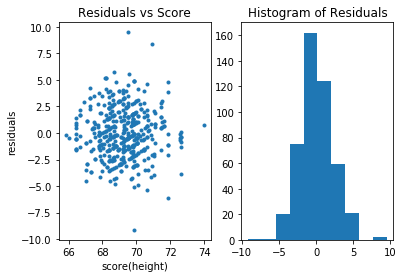

In [36]:
male_predictions = np.dot(M, beta_coeffs) + np.mean(childHeight)
male_resids = male_predictions - childHeight

# Plot the residuals vs score (height)
plt.subplot(1, 2, 1)
plt.plot(male_predictions, male_resids, '.')
plt.ylabel('residuals')
plt.xlabel('score(height)')
plt.title('Residuals vs Score')

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(male_resids)
plt.title('Histogram of Residuals')

# R-squared
#              SSR
# R^2 = 1 -  -------
#              SST

SSR = np.sum(np.square(male_resids))
SST = np.sum(np.square(childHeight - np.mean(childHeight)))

print('SSR: {}'.format(SSR))
print('SST: {}'.format(SST))

R2 = 1.0 - (SSR / SST)

print('R-squared = {}'.format(R2))


## Regularization 2, Ridge and Lasso Regression

So far, we have looked at two approached for dealing with over-parameterized models; feature selection by stepwise regresson and singular value decomposision. In this sectio we will explore the most widely used regularization method for optimization-based machine learning models, ridge regression. 

Let's start by examining the **normal equation** formulation of the linear regresson problem. The goal is to compute a vector of **model coefficients** or weights which minimize the mean squared residuals, given a vector of data $x$ amd a **model matrix** $A$. We can write our model as:

$$x = A b$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

The commonly used Normal Equation form can help:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is an $m x m$ matrix, and thus is of reduced dimension. But, **$A^TA$ can still be rank deficient!** 

The basic idea of ridge regression is to stabalize the inverse sigular value matrix, $D^+=A^{T}A$, by **adding a small bias term**, $\lambda$, to each of the singular values. We can state this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel + \parallel \lambda \cdot b\parallel]\\  or \\
b = (A^TA + \lambda^2)^{-1}A^Tx$$

In this way, the values of small signular values do not blow up when we compute the inverse. You can see this by writing out the $D^+$ matrix with the bias term.

$$D_{ridge}^+  = \begin{bmatrix}
    \frac{1}{d_1 + \lambda^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{d_2 + \lambda^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{d_m + \lambda^2}
\end{bmatrix}$$

Adding this bias term creates a 'ridge' in the singular value matrix, giving this method its name **ridge regression**. 

You can also think of ridge regression as limiting the L2 or Euclidean norm of the values of the model coeficient vector. The value of $\lambda$ determines how much the norm of the coeficient vector constrains the solution. You can see a view of this geometric interpretaton in the figure below.  

![](img/L2.jpg)
<center> **Geometric view of L2 regularization**

The same method goes by some other names, as it seems to have been 'invented' several times. In particular, **Tikhonov regularization**, or **L2 norm regularization**. In all likelihood the method was first developted by the Russian mathematician Andrey Tikhonov in the late 1940's, and first published in english in 1977.

![](img/Tikhonov_board.jpg)
<center> **Commemorative plaque for Andrey Nikolayevich Tikhonov at Moscow State University**

Let's give this a try. Execute the code in the cell below which computes the $(A^TA + \lambda^2)^{-1}A^T$ matrix with a lambda value of `0.1`.

In [37]:
U, s, V = np.linalg.svd(M, full_matrices=False)

# Calculate the inverse singular value matrix from SVD
lambda_val = 1.0
d = np.diag(1. /  (s + lambda_val))

print('Inverse Singular Value Matrix:')
print(d)

# Compute pseudo-inverse
mInv = np.dot(np.transpose(V), np.dot(d, np.transpose(U)))

print('M Inverse')
print(mInv)

Inverse Singular Value Matrix:
[[ 0.03022051  0.          0.          0.        ]
 [ 0.          0.03354784  0.          0.        ]
 [ 0.          0.          0.70606532  0.        ]
 [ 0.          0.          0.          0.72727721]]
M Inverse
[[ 0.00455311  0.0037282   0.0037282  ...,  0.0111813   0.0111813
   0.0111813 ]
 [-0.21447234 -0.08812802 -0.08812802 ...,  0.01207399  0.01207399
   0.01207399]
 [-0.00289452 -0.00214762 -0.00214762 ..., -0.01022436 -0.01022436
  -0.01022436]
 [ 0.22302115  0.09381338  0.09381338 ..., -0.01277817 -0.01277817
  -0.01277817]]


**Your Turn!:** Compute the model coeficients using the $(A^TA + \lambda^2)^{-1}A^T$ matrix you just computed. Give the result a new name and compare these results to the previously computed model coeficients. Call the new vector of model coeficients `b2`.

In [38]:
beta_coeffs_ridge = np.dot(mInv, childHeight)
print('Beta\'s: {}'.format(beta_coeffs_ridge))

Beta's: [-0.36589486  0.69965326  1.12147485  0.21541252]


### Bias-variance trade-off

The statsmodels package allows us to compute a sequence of ridge regression solutions. The code in the cell below computes solutions for `20` values of $\lambda$. Execute this code and examine the values of the model coefficients as $\lambda$ increases.

In [42]:
# Ridge Regression with various penalties in Statsmodels
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 2, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'childHeight ~ mother + father + mother_sqr + father_sqr + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=male_df).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=0)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), childHeight)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(childHeight - np.mean(childHeight)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

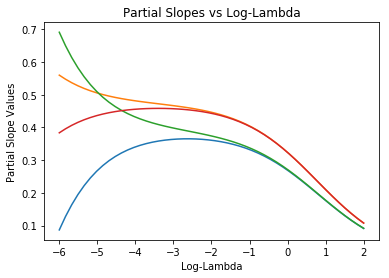

In [43]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

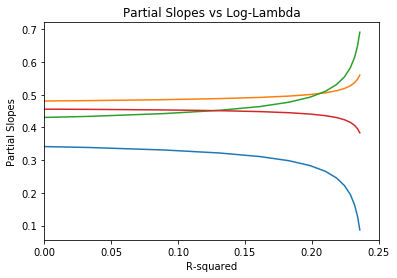

In [44]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs Log-Lambda')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

> Notice that $\lambda$ increases, the values of the 4 model coeficients decrease toward zero. When all coeficients are zero, the model predicts all values of the label as zero! In other words, high values of $\lambda$ give highly biased soluions, but with very low variance. For small values of $\lambda$, the situation is just the oposite. The solution has low bias, but is quite unstable, having maximum variance. This **bias-variance trade off** is a key concept in machine learning.

> Also note how we can get a significant increase in R^2 (from 0 --> ~0.20) without changing the partial slopes much.

### Lasso regression

We can also do regularization using other norms. **Lasso or L1 regularizaton** limits the sum of the absolute values of the model coefients. The L1 norm is sometime know as the **Manhattan norm**, since distrance are measured as if you were traveling on a rectangular grid of streets. 

You can also think of lasso regression as limiting the L1 norm of the values of the model coeficient vector. The value of $\lambda$ determines how much the norm of the coeficient vector constrains the solution. You can see a view of this geometric interpretaton in the figure below.  

![](img/L1.jpg)
<center> **Geometric view of L1 regularization**

By setting the `alpha` argument to `glmnet` to zero you can perform lasso regresson. Execute the code in the cell below to compute and evaluate a lasso regression model with 20 values of lambda.

In [45]:
# Lasso Regression with a sequence of lambdas
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 2, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'childHeight ~ mother + father + mother_sqr + father_sqr + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=male_df).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=1)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), childHeight)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(childHeight - np.mean(childHeight)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

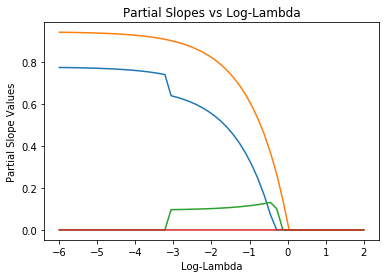

In [46]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

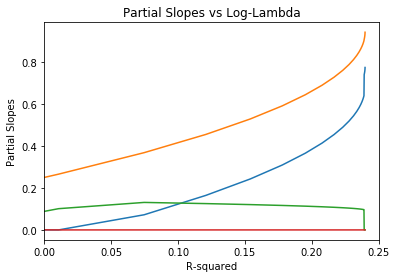

In [47]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs Log-Lambda')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

Notice that model coeficients are much more tightly constrianed than for L2 regularization. In fact, only two of the possible model coeficients have non-zero values at all. This is typical of L1 or lasso regression.

### Elastic net regression

The **elastic net** algorthm uses a weighted combination of L2 and L1 regularization. As you can probably see, the same function is used for Lasso and Ridge regression with only the `L1_wt` argument changing. This argument determines the how much weight goes to the L1-norm of the partial slopes. If `L1_wt = 0`, the regularization is pure L2 (Ridge) and if `L1_wt = 1.0` the regularization is pure L1 (Lasso).

The code in the cell below gives equal weight to each regression method. Excute this code and examine the results.

In [48]:
# Elasticnet Regression with a sequence of lambdas
# Generate a sequence of lambdas
log_lambda_seq = np.linspace(-6, 0, 50)
lambda_seq = np.exp(log_lambda_seq)

coeffs_array = []
rsq_array = []
formula = 'childHeight ~ mother + father + mother_sqr + father_sqr + 1'

for lamb in lambda_seq:
    ridge_model = sm.ols(formula, data=male_df).fit_regularized(method='elastic_net', alpha=lamb, L1_wt=0.75)
    coeffs_array.append(list(ridge_model.params))
    predictions = ridge_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), childHeight)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(childHeight - np.mean(childHeight)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

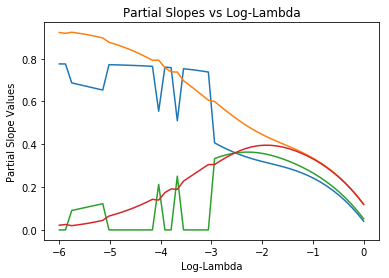

In [49]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
plt.plot(log_lambda_seq, beta_coeffs)
plt.title('Partial Slopes vs Log-Lambda')
plt.ylabel('Partial Slope Values')
plt.xlabel('Log-Lambda')

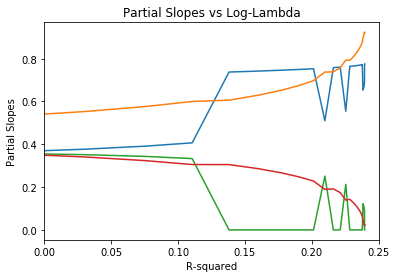

In [50]:
# Plot partial slopes vs R squared (% deviance explained)
plt.plot(rsq_array, beta_coeffs)
plt.xlim([0.0, 0.25])
plt.title('Partial Slopes vs Log-Lambda')
plt.xlabel('R-squared')
plt.ylabel('Partial Slopes')

Notice that the elastic net model combines some of the behaviors of both L2 and L1 regularization. 

## Categorical Variables and the Model Matrix

Up until now we have only been working with numeric data. How can we handle categorical variables in numeric models? 

We need to encode the categorical variables into one or more numeric variables. The common approach is to convert the categorical variable to a set of binary **dummy variables** or **indicator variables**. 

The code in the cell below computes the scaled model data frame. Execute this code and examine the summary of the data frame.

In [51]:
height_data[0:3]

[['1', 78.5, 67.0, 'M', 73.2, 4],
 ['1', 78.5, 67.0, 'F', 69.2, 4],
 ['1', 78.5, 67.0, 'F', 69.0, 4]]

In [52]:
# Create a full Galton data frame that includes Gender
height_data_filtered = [[x[1], x[2], x[3], x[4], x[1]**2, x[2]**2] for x in height_data]
labels = ['father', 'mother', 'gender', 'childHeight', 'father_sqr', 'mother_sqr']
height_df = pd.DataFrame(height_data_filtered, columns = labels)

# Add scaled x to data frame
height_df['father'] = scale(height_df['father'])
height_df['mother'] = scale(height_df['mother'])
height_df['father_sqr'] = scale(height_df['father_sqr'])
height_df['mother_sqr'] = scale(height_df['mother_sqr'])

print(height_df.head())

     father    mother gender  childHeight  father_sqr  mother_sqr
0  3.753584  1.264492      M         73.2    3.974347    1.281902
1  3.753584  1.264492      F         69.2    3.974347    1.281902
2  3.753584  1.264492      F         69.0    3.974347    1.281902
3  3.753584  1.264492      F         69.0    3.974347    1.281902
4  2.538458  1.047642      M         73.5    2.627177    1.054857


Intercept, Slopes : 
Intercept      64.052077
gender[T.M]     5.230829
father         -0.327971
mother         -1.569432
father_sqr      1.327141
mother_sqr      2.310222
dtype: float64
Intercept t-value, Slope t-values: 
Intercept      616.901952
gender[T.M]     36.174581
father          -0.128882
mother          -0.562081
father_sqr       0.521375
mother_sqr       0.827234
dtype: float64

Hypothesis test summary for each coefficient if they differ from zero:
Intercept       0.000000e+00
gender[T.M]    4.251455e-177
father          8.974804e-01
mother          5.742019e-01
father_sqr      6.022349e-01
mother_sqr      4.083257e-01
dtype: float64

SSE, SST, SSR, and RMSE:
SSE: 7370.65233122421
SST: 11515.062371937638
SSR: 4144.410040713428
RMSE: 38.39440670520697
                            OLS Regression Results                            
Dep. Variable:            childHeight   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:              

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


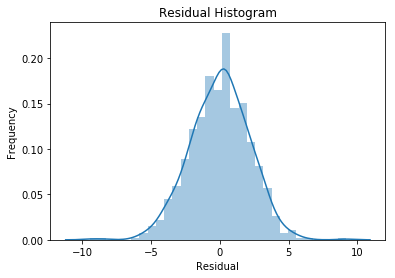

In [53]:
# Fit the OLS with the categorical field 'gender':
ols_model = sm.ols(formula = 'childHeight ~ father + mother + father_sqr + mother_sqr + gender + 1', data=height_df)

results = ols_model.fit()
n_points = height_df.shape[0]
y_output = height_df['childHeight'].reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

# *** Your Turn***

Thinking about dependent features/variables and how they make solving for the inverse computationally hard, why would we want only 1 gender feature and not two, i.e.- 1st: `binary indicator for female` and `binary indicator for male`?

### Answer here:

## Logistic Regresson

Untill now, we have been working strictly with linear regression models. Now we will look at a widely used variation on the linear model know as **logistic regresson**.

Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response, `{False, True}` or `{0, 1}`.  However, the response is computed as a log likelihood. In the simplest case, the response has a Binomial distribution. 

The response of the linear model is transformed to the log likelihood using a sigmodial function, also know as the **logistic function**:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

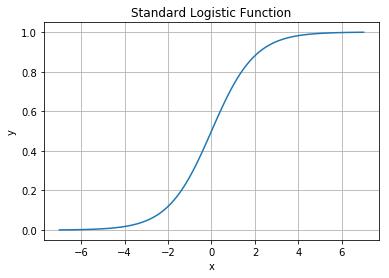

In [55]:
# Plot the logistic transformation function (f(x) above)
x_seq = np.linspace(-7, 7, 100)

def log_fun(x, center=0, scale=1):
    e = np.exp(-scale*(x-center))
    log_out = 1./(1. + e)
    return log_out

log_fun_vectorized = np.vectorize(log_fun)

log_y = log_fun_vectorized(x_seq)

plt.plot(x_seq, log_y)
plt.title('Standard Logistic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continious output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$

### Classification Example

Next, we will try to classify the gender of the childern in the Gaulton families data set using logistic regression on the height data.

As a first step, we need to create a scaled model matrix of the features for the logistic regression. Run the code in the cell bellow to compute this matrix.

In [98]:
# The logit function in Stats models does not take formulas, rather we have to give it arrays/matrices
#  This is very common with ML in python, so it is a good time to get familiar with the format.

# Create intercept column
height_df['intercept'] = 1.0

X_cols = ['father', 'mother', 'childHeight', 'intercept']

X = height_df[X_cols]
Y = np.array([1 if x=='F' else 0 for x in height_df['gender']])

logit_model = sm.Logit(Y, X)

result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.267542
         Iterations 8


In [57]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  898
Model:                          Logit   Df Residuals:                      894
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Nov 2017   Pseudo R-squ.:                  0.6137
Time:                        14:19:31   Log-Likelihood:                -240.25
converged:                       True   LL-Null:                       -621.88
                                        LLR p-value:                4.045e-165
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
father          1.1422      0.136      8.394      0.000       0.876       1.409
mother          0.8534      0.127      6.728      0.000       0.605       1.102
childHeight    -1.1044      0.074    -14.920    

We can generate a `alpha` level of confidence around the parameter estimates with the result method `results.conf_int(alpha=...)` as follows.

In [60]:
# Confidence intervals
# alpha is the % confidence in parameters.
print(result.conf_int(alpha=0.90))

                     0          1
father        1.125088   1.159285
mother        0.837493   0.869372
childHeight  -1.113742  -1.095138
intercept    72.821409  74.057817


If we are interested in how the output probabilities change with respect to the features, we can look at the odds ratio. The odds ratio is just the exponential of the parameters.

These tell us how a 1 unit increase or decrease in a variable affects the odds of being predicting a '1' (Female). For example, we can expect the odds of predicting a female gender to decrease by about 65.9% if we find the childHeight goes down by 1.

In [61]:
# Odds ratio
print(np.exp(result.params))

father         3.133612e+00
mother         2.347691e+00
childHeight    3.313964e-01
intercept      7.841856e+31
dtype: float64


Here is how we can make predictions with our model.

In [76]:
# Standardized Father, Standardized Mother, ChildHeight, 1.0 (intercept)
test_input = np.array([3.7, 1.26, 70.1, 1.0])
test_output = result.predict(test_input)
print('Probability of Female: {}'.format(test_output))

Probability of Female: [ 0.78914478]


Finding out the effect of `childHeight` on the probabilities graphically:

Here we will loop over a sequence of childHeights to see the effect of them on the probability of a Female gender.

In [88]:
childHeight_seq = np.linspace(height_df['childHeight'].min(), height_df['childHeight'].max(), 100)

avg_father = height_df['father'].mean()
avg_mother = height_df['mother'].mean()

childHeight_df = pd.DataFrame(childHeight_seq, columns=['childHeight'])
childHeight_df['father'] = height_df['father'].mean() # hopefully close to zero
childHeight_df['mother'] = height_df['mother'].mean() # hopefully close to zero
childHeight_df['intercept'] = 1.0

# Rearrange order of columns appropriately
childHeight_df = childHeight_df[['father', 'mother', 'childHeight', 'intercept']]

# Get probability predictions
gender_prob_childHeight = result.predict(childHeight_df)

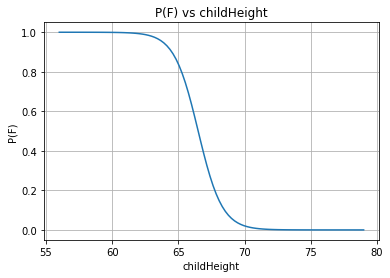

In [92]:
plt.plot(childHeight_seq, gender_prob_childHeight)
plt.title('P(F) vs childHeight')
plt.xlabel('childHeight')
plt.ylabel('P(F)')
plt.grid()

We are also interested in evaluating our classifier's accuracy.  Here we will look at how many are:

 - True Positives (TP): We predicted Female and the actual gender was Female.
 - True Negatives (TN): We predicted Male and the actual gender was Male.
 - False Positives (FP): We predicted Female and the actual gender was Male.
 - False Negatives (FN): We predicted Male and the actual gender was Female.

The output of our predictions is a probability.  In order to make this a binary prediction (Female or male), we need to decide a cutoff.  Commonly, we choose 0.5 as a cutoff.  But know that this choice is arbitrary and we can set it to whatever probability we choose.  If we have a model where False Positives are costly, we might decide to increase the cutoff, and vice-versa if False Negatives are more costly.

In [104]:
prediction_frame = X.copy()

prediction_frame['probability'] = result.predict(X)

prediction_frame['actual'] = Y

cutoff = 0.5
def prediction_fun(row):
    if row['probability'] > 0.5:
        return 1.0
    else:
        return 0.0
    

prediction_frame['prediction'] = prediction_frame.apply(prediction_fun, axis=1)

In [105]:
prediction_frame.head()

,father,mother,childHeight,intercept,probability,actual,prediction
0,3.753584,1.264492,73.2,1.0,0.115174,0,0.0
1,3.753584,1.264492,69.2,1.0,0.915197,1,1.0
2,3.753584,1.264492,69.0,1.0,0.930842,1,1.0
3,3.753584,1.264492,69.0,1.0,0.930842,1,1.0
4,2.538458,1.047642,73.5,1.0,0.019017,0,0.0


Now let's calculate the accuracy, true positives, true negatives, false positives, and false negatives.

In [112]:
TP = np.sum([a == 1.0 and p == 1.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])
TN = np.sum([a == 0.0 and p == 0.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])

FP = np.sum([a == 0.0 and p == 1.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])
FN = np.sum([a == 1.0 and p == 0.0 for a, p in zip(prediction_frame['actual'], prediction_frame['prediction'])])

num_obs = prediction_frame.shape[0]

print('Out of {} observations:'.format(num_obs))
print('TP: {}, TN: {}'.format(TP, TN))
print('\nFP: {}, FN: {}'.format(FP, FN))

accuracy = (TP + TN) / num_obs
print('\nAccuracy over two classes: {}'.format(accuracy))

Out of 898 observations:
TP: 384, TN: 411

FP: 54, FN: 49

Accuracy over two classes: 0.8853006681514477


We can view these results in a table with a confusion matrix as follows:

In [118]:
print('Actual = columns')
print('\nPredicted = rows')
print('\n   0.0   1.0')
print('----------------')
print(result.pred_table(threshold=cutoff))

Actual = columns

Predicted = rows

   0.0   1.0
----------------
[[ 411.   54.]
 [  49.  384.]]


In the confusion matrix males are defined as Positive cases and females are Negtive cases. Notice that most of the cases in this data are correctly classified with only a few false negatives and false positives.

The other metrics are defined as follows:

- Accuracy = (TP + TN) / (TP + FP + TN + FN)
- Precision = TP / (TP + FP)
   - Precision is the fraction of the relevant class predictions are actually correct.
- Recall = TP / (TP + FN)
   - Recall is the fraction of the relevant class were we able to predict.

These summary statistics show the classifier works fairly well.